## imports

In [1]:
#importing packages
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# import re
import string

# nltk
import nltk
# from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# gensim
from gensim.models import Word2Vec

%matplotlib inline

## Data process
train data: https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

In [2]:
train = pd.read_csv('../data/train.csv', encoding = "ISO-8859-1", engine='python')
test  = pd.read_csv('../data/test.csv', encoding = "ISO-8859-1", engine='python')
train
# test

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?Ã°ÂÂÂÃ°ÂÂÂÃ°ÂÂ...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [3]:
#putting train and test together
combi = train.append(test, ignore_index=True)

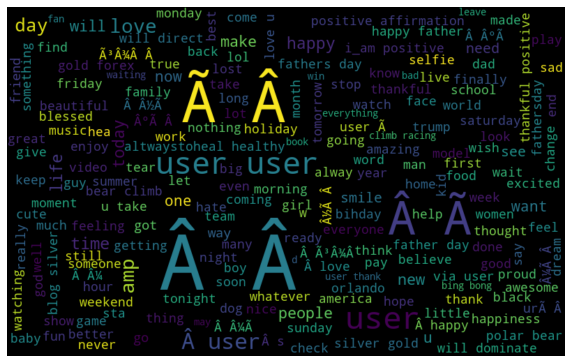

In [4]:
sentences = combi['tweet'].tolist()
sentences_ss = " ".join(sentences)

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(sentences_ss)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## clean tweet text

In [5]:
combi['cleanTweet'] = combi['tweet']
combi.head()

,id,label,tweet,cleanTweet
0,1,0.0,@user when a father is dysfunctional and is s...,@user when a father is dysfunctional and is s...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,@user @user thanks for #lyft credit i can't us...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


In [6]:
combi['cleanTweet'] = combi['tweet'].map(lambda x: re.sub('@\S+', ' ', x))
combi.head()

,id,label,tweet,cleanTweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so se...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause ...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


In [7]:
#upper case to lower case
combi['cleanTweet'] = combi['cleanTweet'].map(lambda x: x.lower())
#remove number
combi['cleanTweet'] = combi['cleanTweet'].map(lambda x: re.sub(r'\d+', '', x))
#remove punctuation
combi['cleanTweet'] = combi['cleanTweet'].map(lambda x: x.translate(x.maketrans('', '', string.punctuation)))
#remove whitespace
combi['cleanTweet'] = combi['cleanTweet'].map(lambda x: x.strip())
#remove url
url_cleaner = "https?:\S+|http?:\S|[^A-Za-z0-9]+"
combi['cleanTweet'] = combi['cleanTweet'].map(lambda x: re.sub(url_cleaner, ' ', x))
#removing small words
combi['cleanTweet'] = combi['cleanTweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# Replace 3 or more consecutive letters by 2 letter.
combi['cleanTweet'] = combi['cleanTweet'].map(lambda x: re.sub(r"(.)\1\1+", r"\1\1", x))
combi

,id,label,tweet,cleanTweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit cant cause they dont offer ...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society motivation
...,...,...,...,...
49154,49155,NaN,thought factory: left-right polarisation! #tru...,thought factory leftright polarisation trump u...
49155,49156,NaN,feeling like a mermaid Ã°ÂÂÂ #hairflip #nev...,feeling like mermaid hairflip neverready forma...
49156,49157,NaN,#hillary #campaigned today in #ohio((omg)) &am...,hillary campaigned today ohioomg used words li...
49157,49158,NaN,"happy, at work conference: right mindset leads...",happy work conference right mindset leads cult...


In [8]:
#Tokenization
tokenized_tweet = combi['cleanTweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, lyft, credit, cant, cause, they, dont...
2                              [bihday, your, majesty]
3                      [model, love, take, with, time]
4                    [factsguide, society, motivation]
Name: cleanTweet, dtype: object

In [9]:
# Removing Consecutive letters
words_with_consecutive_letters = ['little', 'called', 'better', 'common', 'cannot', 'matter', 'middle',
 'follow', 'choose', 'letter', 'killed', 'summer', 'battle', 'supply', 'bottom', 'passed', 'button',
 'manner', 'happen', 'speech', 'troops', 'filled', 'latter', 'yellow', 'dinner', 'coffee', 'fellow', 'tissue',
 'hidden', 'smooth', 'pulled', 'narrow', 'lesson', 'missed', 'cattle', 'winner', 'bigger', 'valley', 'dollar',
 'suffer', 'mirror', 'passes', 'losses', 'terror', 'cotton', 'summit', 'cheese', 'bottle', 'freely', 'vessel',
 'sheets', 'sudden', 'copper', 'fallen', 'differ', 'gotten', 'buffer', 'banner', 'ball',
 'been', 'beer', 'beet', 'beep', 'bell', 'boom', 'boot', 'book', 'bull', 'butt', 'call', 'cell', 'coon',
 'dell', 'doll', 'door', 'doom', 'fall', 'fell', 'feel', 'feet', 'foot', 'food', 'fool', 'fuss',
 'full', 'gull', 'gall', 'hall', 'hell', 'heed', 'heel', 'hill', 'hull', 'all', 'add', 'bee', 'boo',
 'ell', 'ebb', 'egg', 'fee', 'goo', 'too', 'tee', 'see', 'Hollywood', 'bookkeeping', 'aloofness',
 'foolishness', 'woodcutter', 'bulletproof', 'bootlegging', 'bittersweet', 'schoolfellow', 'committee',
 'wheelbarrow', 'boorishness', 'bookkeeper', 'beerbelly', 'look', 'tomorrow', 'will', 'school', 'weekend']

tokenized_tweet = tokenized_tweet.apply(lambda text: [word if word in words_with_consecutive_letters else re.sub(r"(.)\1+", r"\1", word) for word in text])
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, lyft, credit, cant, cause, they, dont...
2                              [bihday, your, majesty]
3                      [model, love, take, with, time]
4                    [factsguide, society, motivation]
Name: cleanTweet, dtype: object

In [10]:
# Removing stop words
stop_words = set(stopwords.words('english'))
tokenized_tweet = tokenized_tweet.apply(lambda text: [word for word in text if word not in stop_words])
tokenized_tweet.head()

0    [father, dysfunctional, selfish, drags, kids, ...
1    [thanks, lyft, credit, cant, cause, dont, ofer...
2                                    [bihday, majesty]
3                            [model, love, take, time]
4                    [factsguide, society, motivation]
Name: cleanTweet, dtype: object

In [11]:
# stemming
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_tweet.head()

0     [father, dysfunct, selfish, drag, kid, dysfunct]
1    [thank, lyft, credit, cant, caus, dont, ofer, ...
2                                    [bihday, majesti]
3                            [model, love, take, time]
4                          [factsguid, societi, motiv]
Name: cleanTweet, dtype: object

In [12]:
# Lemmatizing the words using WordNet
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text)
    # pos_tagged_text = text.apply(lambda x: nltk.pos_tag(x))
    return [lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text]

tokenized_tweet = tokenized_tweet.apply(lambda text: lemmatize_words(text))
tokenized_tweet.head()

0     [father, dysfunct, selfish, drag, kid, dysfunct]
1    [thank, lyft, credit, cant, caus, dont, ofer, ...
2                                    [bihday, majesti]
3                            [model, love, take, time]
4                          [factsguid, societi, motiv]
Name: cleanTweet, dtype: object

In [13]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
combi['cleanTweet'] = tokenized_tweet
combi

,id,label,tweet,cleanTweet
0,1,0.0,@user when a father is dysfunctional and is s...,father dysfunct selfish drag kid dysfunct
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thank lyft credit cant caus dont ofer whelchai...
2,3,0.0,bihday your majesty,bihday majesti
3,4,0.0,#model i love u take with u all the time in ...,model love take time
4,5,0.0,factsguide: society now #motivation,factsguid societi motiv
...,...,...,...,...
49154,49155,NaN,thought factory: left-right polarisation! #tru...,think factori leftright polaris trump uselect ...
49155,49156,NaN,feeling like a mermaid Ã°ÂÂÂ #hairflip #nev...,fele like mermaid hairflip nevereadi formal we...
49156,49157,NaN,#hillary #campaigned today in #ohio((omg)) &am...,hilari campaign today ohiomg use word like ase...
49157,49158,NaN,"happy, at work conference: right mindset leads...",hapi work confer right mindset lead cultureofd...


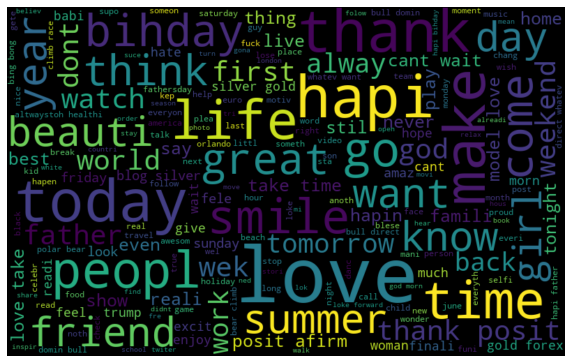

In [14]:
all_words = ' '.join([text for text in combi['cleanTweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [15]:
# Importing the built-in logging module
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [16]:
# Creating the model and setting values for the various parameters
num_features = 400  # Word vector dimensionality
min_word_count = 1 # Minimum word count
num_workers = 6     # Number of parallel threads
context = 10       # Context window size
downsampling = 1e-3 # (0.001) Downsample setting for frequent words

tokenized_tweet = combi['cleanTweet'].apply(lambda x: x.split())

# print("Training model....")
w2v_model = Word2Vec(sentences=tokenized_tweet,workers=num_workers,min_count=min_word_count,window=context,sample=downsampling)
# model.build_vocab(data['cleanTweet'])

2021-02-05 03:03:03,286 : INFO : collecting all words and their counts
2021-02-05 03:03:03,287 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-02-05 03:03:03,306 : INFO : PROGRESS: at sentence #10000, processed 66722 words, keeping 14498 word types
2021-02-05 03:03:03,324 : INFO : PROGRESS: at sentence #20000, processed 132681 words, keeping 22779 word types
2021-02-05 03:03:03,342 : INFO : PROGRESS: at sentence #30000, processed 198922 words, keeping 29708 word types
2021-02-05 03:03:03,361 : INFO : PROGRESS: at sentence #40000, processed 264796 words, keeping 36033 word types
2021-02-05 03:03:03,378 : INFO : collected 41206 word types from a corpus of 325639 raw words and 49159 sentences
2021-02-05 03:03:03,379 : INFO : Loading a fresh vocabulary
2021-02-05 03:03:03,445 : INFO : effective_min_count=1 retains 41206 unique words (100% of original 41206, drops 0)
2021-02-05 03:03:03,445 : INFO : effective_min_count=1 leaves 325639 word corpus (100% of ori

In [17]:
w2v_model.train(combi['cleanTweet'], total_examples=w2v_model.corpus_count, epochs=60)

# To make the model memory efficient
w2v_model.init_sims(replace=False)

# Saving the model for later use. Can be loaded using Word2Vec.load()
model_name = "word2vec"
w2v_model.save(model_name)

2021-02-05 03:03:13,919 : WARNING : Effective 'alpha' higher than previous training cycles
2021-02-05 03:03:13,920 : INFO : training model with 6 workers on 41206 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=10
2021-02-05 03:03:14,245 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-02-05 03:03:14,246 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-02-05 03:03:14,247 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-02-05 03:03:14,247 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-02-05 03:03:14,247 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-02-05 03:03:14,248 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-02-05 03:03:14,248 : INFO : EPOCH - 1 : training on 2117250 raw words (597005 effective words) took 0.3s, 1838597 effective words/s
2021-02-05 03:03:14,574 : INFO : worker thread finished; awaiting finish of

In [18]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]

    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]

    plt.figure(figsize=(10,10))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)
    plt.savefig('./plot.png', dpi=800)

## Test word2vec

In [19]:
w2v_model.wv.most_similar("father")

[('dad', 0.9908317923545837),
 ('fathersday', 0.9896804094314575),
 ('dadi', 0.9806638360023499),
 ('papa', 0.9801282286643982),
 ('daygod', 0.9677609205245972),
 ('equiti', 0.9620485305786133),
 ('dadsday', 0.9618009924888611),
 ('shinpad', 0.9601263999938965),
 ('brimston', 0.9583351016044617),
 ('flcrashcorector', 0.9576927423477173)]

In [20]:
w2v_model.wv.vocab

{'father': <gensim.models.keyedvectors.Vocab at 0x7ff39ac3ae50>,
 'dysfunct': <gensim.models.keyedvectors.Vocab at 0x7ff39f9385d0>,
 'selfish': <gensim.models.keyedvectors.Vocab at 0x7ff39f938690>,
 'drag': <gensim.models.keyedvectors.Vocab at 0x7ff38c1b7410>,
 'kid': <gensim.models.keyedvectors.Vocab at 0x7ff38c1b7890>,
 'thank': <gensim.models.keyedvectors.Vocab at 0x7ff38c1b7750>,
 'lyft': <gensim.models.keyedvectors.Vocab at 0x7ff38c1b74d0>,
 'credit': <gensim.models.keyedvectors.Vocab at 0x7ff38c1b7310>,
 'cant': <gensim.models.keyedvectors.Vocab at 0x7ff38c1b7850>,
 'caus': <gensim.models.keyedvectors.Vocab at 0x7ff38c1b7590>,
 'dont': <gensim.models.keyedvectors.Vocab at 0x7ff38c1b73d0>,
 'ofer': <gensim.models.keyedvectors.Vocab at 0x7ff38c1b7610>,
 'whelchair': <gensim.models.keyedvectors.Vocab at 0x7ff38c1b7510>,
 'van': <gensim.models.keyedvectors.Vocab at 0x7ff38c1b78d0>,
 'disapoint': <gensim.models.keyedvectors.Vocab at 0x7ff38c1b7910>,
 'gethank': <gensim.models.keyedvec

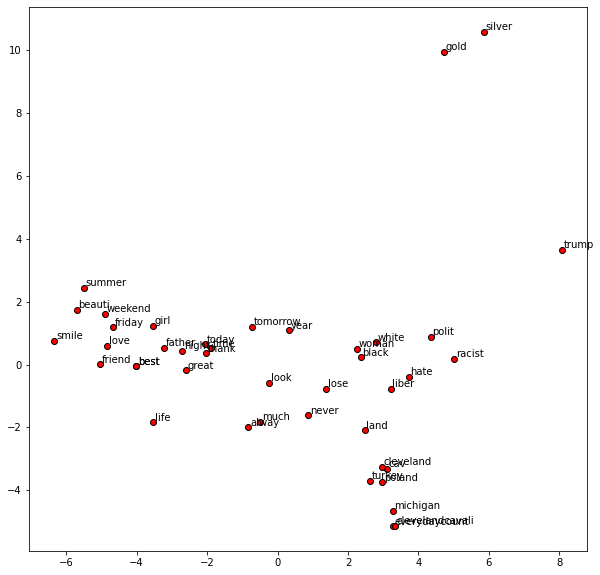

In [21]:
display_pca_scatterplot(w2v_model,
                        ['friend', 'great', 'love', 'life', 'girl', 'beauti', 'smile',
                         'summer', 'thank', 'time', 'today', 'weekend', 'father', 'polit',
                         'alway', 'year', 'best', 'tomorrow', 'land', 'cav', 'white', 'woman',
                         'friday', 'night', 'never', 'trump', 'much', 'lose', 'best', 'black',
                         'cleveland', 'poland', 'turkey', 'silver', 'gold', 'everydaycount',
                         'hate', 'clevelandcavali', 'michigan', 'liber', 'look', 'racist'])

## TF-IDF

In [22]:
# tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf_vectorizer = TfidfVectorizer()
# TF-IDF feature matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(combi['cleanTweet'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [23]:
w2v_model.wv.syn0.shape

(41206, 100)

In [24]:
def make_feature_vec(words, model, num_features, tfidf_scores):
    """
    Average the word vectors for a set of words
    """
    feature_vec = np.zeros((num_features,),dtype="float32")  # pre-initialize (for speed)
    nwords = 0.
    index2word_set = set(model.index2word)  # words known to the model

    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            weight = 1
            if word in tfidf_scores:
                weight = tfidf_scores[word]
            feature_vec = np.add(feature_vec,model[word] * weight)

    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec

def get_avg_feature_vecs(sents, model, num_features, tfidf_list):
    """
    Calculate average feature vectors for all reviews
    """
    counter = 0
    sent_feature_vecs = np.zeros((len(sents),num_features), dtype='float32')  # pre-initialize (for speed)

    feature_index = tfidf_matrix[counter,:].nonzero()[1]

    for sent in sents:
        sent_feature_vecs[counter] = make_feature_vec(sent, model, num_features, tfidf_list[counter])
        counter = counter + 1
    return sent_feature_vecs

In [25]:
index_value={i[1]:i[0] for i in tfidf_vectorizer.vocabulary_.items()}
fully_indexed = []
for row in tfidf_matrix:
    fully_indexed.append({index_value[column]:value for (column,value) in zip(row.indices,row.data)})

data = get_avg_feature_vecs(tokenized_tweet, w2v_model.wv, 100, fully_indexed)
data

array([[ 0.10519885, -0.08900038, -0.10543271, ...,  0.06120504,
        -0.24473768, -0.06944431],
       [ 0.08564105, -0.01646153, -0.10145417, ...,  0.04126946,
        -0.24250959, -0.14498024],
       [ 0.29824677, -0.43220916, -0.43944117, ...,  0.25497746,
        -0.56640685, -0.49538767],
       ...,
       [ 0.12756439, -0.03091092, -0.1086826 , ...,  0.05571627,
        -0.26341268, -0.13908046],
       [ 0.16514727, -0.10424274, -0.14925817, ..., -0.01974652,
        -0.9030808 , -0.3936462 ],
       [ 0.10914037, -0.07804639, -0.14797403, ...,  0.06070573,
        -0.20771074, -0.11438853]], dtype=float32)

# Classification Models

In [26]:
train_data  = data[:31962]
# test_data   = data[25569:]
# train_label = combi['label'].to_numpy()[:25569]
# test_label  = combi['label'].to_numpy()[25569:]

# train_data.shape
# np.isnan(train_data).any()
train_data = np.nan_to_num(train_data)

# splitting data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(train_data, train['label'], random_state=42, test_size=0.3)

In [27]:
# def model_Evaluate(model, xtest):
def modelResult(y_pred):

    # Predict values for Test dataset
    # y_pred = model.predict(xtest)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    plt.savefig("./result.png")

## Random Forest

In [28]:
forest = RandomForestClassifier(n_estimators = 1000, random_state = 50)
forest = forest.fit(X_train, y_train)
forest_y_pred = forest.predict(X_test)

forest.score(X_test, y_test)

0.9485869225153822

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      8905
           1       0.83      0.35      0.50       684

    accuracy                           0.95      9589
   macro avg       0.89      0.67      0.73      9589
weighted avg       0.94      0.95      0.94      9589



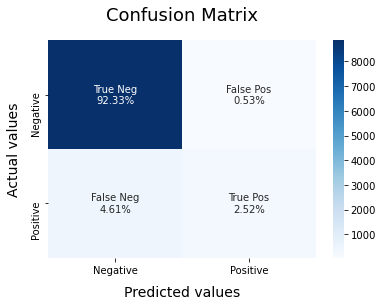

In [29]:
modelResult(forest_y_pred)

## LinearSVC

In [48]:
pca = PCA(n_components=15)

lsvm_X_train = pca.fit_transform(X_train)
lsvm_X_test  = pca.transform(X_test)

SVCmodel = LinearSVC()
SVCmodel.fit(lsvm_X_train, y_train)
lsvm_y_pred = SVCmodel.predict(lsvm_X_test)

SVCmodel.score(lsvm_X_test, y_test)

0.9309625612681197

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      8905
           1       0.78      0.05      0.09       684

    accuracy                           0.93      9589
   macro avg       0.85      0.52      0.52      9589
weighted avg       0.92      0.93      0.90      9589



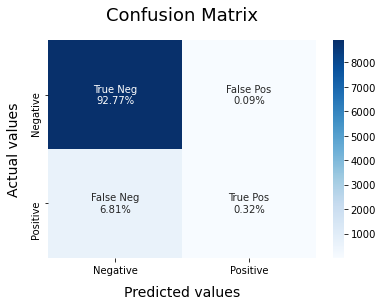

In [49]:
modelResult(lsvm_y_pred)

## svm with rbf

In [54]:
rbfSVCmodel = SVC(kernel='rbf', gamma=0.5, C=0.5)
rbfSVCmodel.fit(X_train, y_train)
rbf_svm_y_pred = rbfSVCmodel.predict(X_test)

rbfSVCmodel.score(X_test, y_test)

0.9352382938784023

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8905
           1       0.87      0.11      0.19       684

    accuracy                           0.94      9589
   macro avg       0.90      0.55      0.58      9589
weighted avg       0.93      0.94      0.91      9589



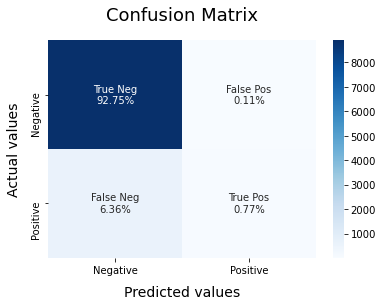

In [55]:
modelResult(rbf_svm_y_pred)
